# Understanding Overcooked

In [28]:
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv, Overcooked
from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer
from overcooked_ai_py.mdp.actions import Action
from overcooked_ai_py.agents.agent import Agent, RandomAgent, FixedPlanAgent
import numpy as np
import matplotlib.pyplot as plt

In [29]:
base_mdp = OvercookedGridworld.from_layout_name("cramped_room") #or other layout
base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=400)
env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

In [30]:
random_agent_1 = RandomAgent(all_actions=True)
random_agent_2 = RandomAgent(all_actions=True)

The action returned by agent.action(state) is a tuple containing the action and a dictionary with additional info. in the case of the random agent, it contains the probability of selecting each action.

In [31]:
obs = env.reset()
action1 = random_agent_1.action(obs)
action2 = random_agent_2.action(obs)
print(f"action: {action1}")
print(f"action: {action2}")

action: ((-1, 0), {'action_probs': array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])})
action: ((-1, 0), {'action_probs': array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])})


The action class has several dictionaries in order to map the action returned by the agent into various formats.

In [32]:
print(f"ACTION_TO_INDEX : {Action.ACTION_TO_INDEX}")
print(f"ACTION_TO_CHAR : {Action.ACTION_TO_CHAR}")

ACTION_TO_INDEX : {(0, -1): 0, (0, 1): 1, (1, 0): 2, (-1, 0): 3, (0, 0): 4, 'interact': 5}
ACTION_TO_CHAR : {(0, -1): '↑', (0, 1): '↓', (1, 0): '→', (-1, 0): '←', (0, 0): 'stay', 'interact': 'interact'}


The state returned by the env.step() or env.reset() is a dictionary containing various info:
- **both_agent_obs** is the observation of each agent. It is a vectorized representation, containing info such as agents' position, orientation, distance from the ingredients, etc. The POV is given by env.agent_idx()
- **overcooked_state** is an object of the OvercookedState class (overcooked_mdp.py) and it contains various info about the state, like overcooked_state.players_position and overcooked_state.players_orientation
- **other_agent_env_idx**: it represents the index of the agent which is considered to be not the main one. at every reset() and step() of the environment, the state will randomly output the state in the POV of one of the 2 agents.  
`From overcooked_env official documentation:` observation is formatted to be standard input for self.agent_idx's policy

In [33]:
obs = env.reset()
both_agent_obs, overcooked_state, other_agent_env_idx = (v for v in obs.values())
obs

{'both_agent_obs': (array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., -2.,
          2.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,
          0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0., -1., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,
          1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
          1., -2.,  1.,  3.,  1.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  1., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  1.,  0.,  0.,  0., -2.,  2.,  0.,  0.,  0.,  0.,  0.,
          2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,

You can see all the attributes encoded inside overcooked_state with to_dict() method

In [34]:
print(f"You can see all the attributes encoded inside overcooked_state with to_dict() method")
overcooked_state.to_dict()

You can see all the attributes encoded inside overcooked_state with to_dict() method


{'players': [{'position': (1, 2), 'orientation': (0, -1), 'held_object': None},
  {'position': (3, 1), 'orientation': (0, -1), 'held_object': None}],
 'objects': [],
 'bonus_orders': [],
 'all_orders': [{'ingredients': ('onion', 'onion', 'onion')}],
 'timestep': 0}

env.render() generates an rgb images of the game

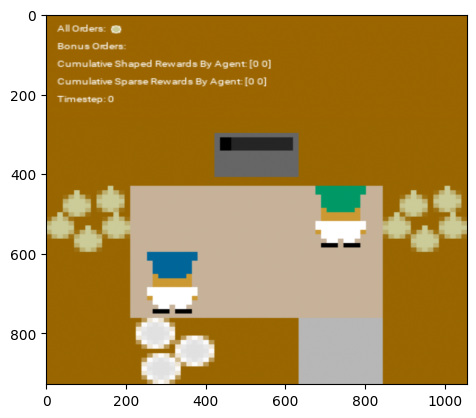

In [35]:
render = env.render() / 255.0
plt.imshow(render)

In [36]:
obs['overcooked_state'].player_positions

((1, 2), (3, 1))

In [37]:
player_1_action = Action.ACTION_TO_INDEX[action1[0]]
print(f"Action chosen by the player1: {Action.ACTION_TO_CHAR[action1[0]]}")
player_2_action = Action.ACTION_TO_INDEX[action2[0]]
print(f"Action chosen by the player2: {Action.ACTION_TO_CHAR[action2[0]]}")

Action chosen by the player1: ←
Action chosen by the player2: ←


The action required by the environment must be a Tuple containing the 2 action performed by the agents in **index format**
env.step() returns the observation, reward, done, env_info 

In [38]:
action = (player_1_action, player_2_action)
new_obs, reward, done, env_info = env.step(action)

In [39]:
new_obs['overcooked_state'].players_pos_and_or

(((1, 2), (-1, 0)), ((2, 1), (-1, 0)))

Player1 is the one on the left, Player2 is the one on the right. But how do i understand the POV of the observation state? Sometimes the 'other_agent_env_idx' is 1, and sometimes is 0.

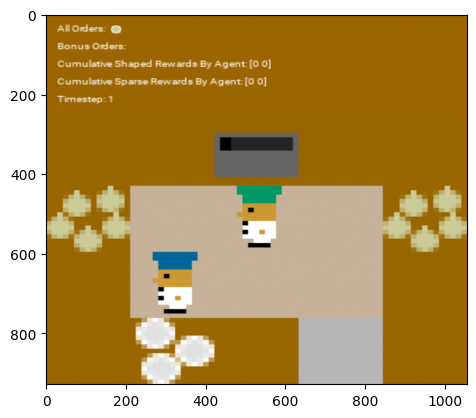

In [40]:
render = env.render() / 255.0
plt.imshow(render)

You can insepect the current main agent through env.agent_idx

In [41]:
print(f"main agent index: {env.agent_idx}")

main agent index: 1


You probably need to implement your agent class.

In [ ]:
class MyAgent(Agent):
    def __init__(self):
        super().__init__()

    def action(self, state):
        """
        We want to output the action given the state. can use a NN!
        """
        pass

    def actions(self, states):
        pass

    def update(self, state, reward):
        """
        What do we need to update?
        """
        pass

0

Let's see an example

In [82]:
base_mdp = OvercookedGridworld.from_layout_name("cramped_room") #or other layout
base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=400)
env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

agent_1 = RandomAgent(all_actions=True)
agent_2 = RandomAgent(all_actions=True)

Episode terminated at timestep 400


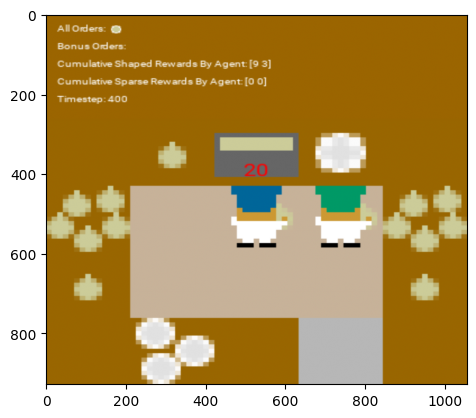

In [93]:
obs = env.reset()
done = False
t = 0
while not done or t>10000:
    action1 = agent_1.action(obs)
    action2 = agent_2.action(obs)
    player_1_action = Action.ACTION_TO_INDEX[action1[0]]
    player_2_action = Action.ACTION_TO_INDEX[action2[0]]
    action = (player_1_action, player_2_action)
    new_obs, reward, done, env_info = env.step(action)
    if reward != 0:
        print(f"reward: {reward}")
    t += 1
print(f"Episode terminated at timestep {t}")

render = env.render() / 255.0
plt.imshow(render)
plt.show()

# Understanding Tensorflow Keras

In [52]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model

To compute custom gradients you need to use tf.GradientTape() to store the computations. The tape allows you to compute the gradients only with respect to variables which are "watched" by the tape. By default, those are of the tf.Variable kind.  
If you want to compute the gradients with respect to the tf.tensor kind, you need to explicitly call tape.watch().  
If you want to manually select which variables to watch, use the watch_accessed_variables=False as a parameter of the tf.GradientTape() and manually watch the preferred variables.    
The __exit__() guard of the with tf.GradientTape() is executed (resources are freed) as soon as you call tape.gradient() to compute the gradient. To perform multiple gradient calculations, use persistent=True as a parameter in the with statement (tf.GradientTape(persistent=True))

In [43]:
x = tf.Variable(3.0)
y = tf.constant(3.0)
with tf.GradientTape(persistent=True) as tape:
    tape.watch(y)
    z = x**2
    w = z/y 

dz_dx = tape.gradient(z, x)
dw_dy = tape.gradient(w, y)
print(f"dz_dx = {dz_dx.numpy()}")
print(f"dw_dy = {dw_dy.numpy()}")
del tape # to manually free the resources

# Gradients are computed for scalars, if you
# compute it for tensors you will have the 
# sum of the gradients of each scalar in the tensor.
# If you are computing the gradient of an N-dimensional
# scalar wrt an N-dimensional scalar (e.g. derivative of 
# a function) you will compute the point-wise gradient.

x = tf.linspace(-10.0, 10.0, 10)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)
print(f"dy_dx = {dy_dx.numpy()}")

dz_dx = 6.0
dw_dy = -1.0
dy_dx = [4.5395798e-05 4.1859146e-04 3.8362022e-03 3.3258740e-02 1.8632644e-01
 1.8632644e-01 3.3258699e-02 3.8362255e-03 4.1860685e-04 4.5416677e-05]


In [80]:
class Policy(Model):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.input_a = Input(shape=(self.input_shape))
        self.input_b = Input(shape=(self.input_shape))
        self.concatenate_inputs = Concatenate()
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(128, activation='relu')
        self.policy_a = layers.Dense(self.num_actions, activation='softmax', name="policy_a")
        self.policy_b = layers.Dense(self.num_actions, activation='softmax', name="policy_b")

    def call(self, inputs, training=False):
        # agent_a = self.input_a(inputs[0])
        # agent_b = self.input_b(inputs[1])
        x = self.concatenate_inputs(inputs)
        x = self.dense_1(x)
        x = self.dense_2(x)
        policy_a = self.policy_a(x)
        policy_b = self.policy_b(x)
        return (policy_a, policy_b)

    # def build_model(self):
    #     self.embedding.build(self.input_shape)
    #     self.bidirectional_lstm_1.build(self.embedding.compute_output_shape(self.input_shape))
    #     self.bidirectional_lstm_2.build(self.bidirectional_lstm_1.compute_output_shape(self.input_shape))
    #     self.classifier.build(self.bidirectional_lstm_2.compute_output_shape(self.input_shape))
    
    def fit(self,):
        pass

In [81]:
agent_1_obs = obs['both_agent_obs'][0]
agent_2_obs = obs['both_agent_obs'][1]
mypolicy = Policy(input_shape=agent_1_obs.shape, num_actions=Action.NUM_ACTIONS)
inputs = (tf.expand_dims(agent_1_obs, axis=0), tf.expand_dims(agent_2_obs, axis=0))
mypolicy(inputs) 
# tf.expand_dims is necessary as the model expects 
# another dimension which is the batch size

(<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[0.16656172, 0.21462901, 0.30898443, 0.08529613, 0.11682219,
         0.10770658]], dtype=float32)>,
 <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[0.06143473, 0.11587619, 0.07687225, 0.04131411, 0.5793361 ,
         0.1251666 ]], dtype=float32)>)